In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use("seaborn")

## Modified model with VGG-19 Arhcitecture via Early-Exit block implementation on MNIST + Omniglot datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру (див. рис.1,2), але без використання Early-Exit блоку.

### Розроблена модель
Для проведення досліджень за основу було використано архітектуру згорткової нейронної мережі VGG-19. У модель, у якій реалізовано таку архітектуру, після першого блоку в згортковій основі було додано користувацький EЕ-блок (див. рис.3). Його головна мета полягяє у відсіюванні надлишкових зображень на ранніх етапах обчислень, щоб зекономити ресурси моделі при класифікації необхідних зображень. Ефективна реалiзацiя такої моделі на практицi дає змогу в наперед визначених місцях обчислювального графа динамічно обирати шлях під час отримання результату.

EE-блок створений на основі шарів максимізаційного агрегування (MaxPooling) та повністю зв'язних шарів (Fully-Connected, Dense), структура яких аналогічна до шарів у VGG-19 архітектурі. Також цей блок складається з шару, який вирівнює форму результату попереднього шару (Flatten). Це зроблено з метою застосування на останньому етапі повністю зв'язного шару, який на виході буде давати результат розподілу ймовірностей бінарної класифікації за допомогою функції активації $softmax$. Саме на цьому етапі модель буде визначати, чи зображення належить до надлишкового класу зображень, які не потребують подальшої класифікації.

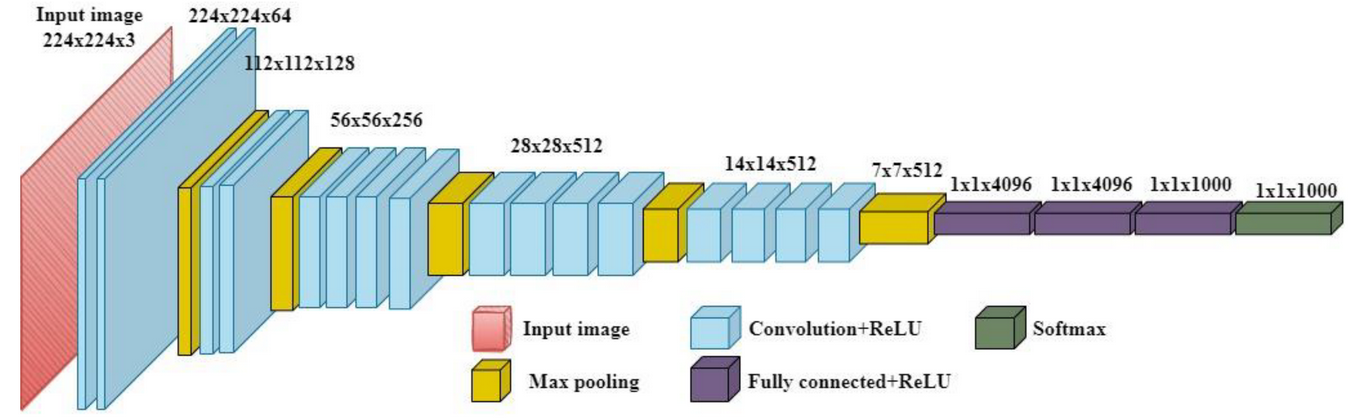
### *Рис.1: Модель на основі VGG-19 архітектури.*

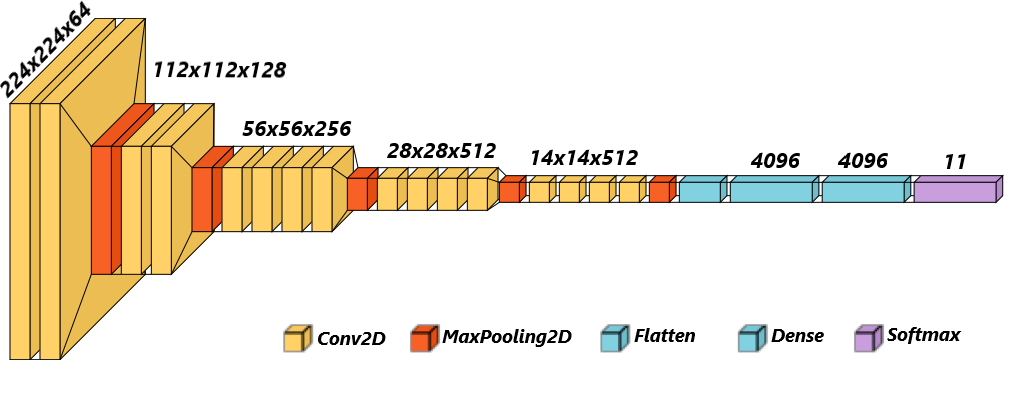
### *Рис.2: Модель на основі VGG-19 архітектури, використана у поданій роботі.*

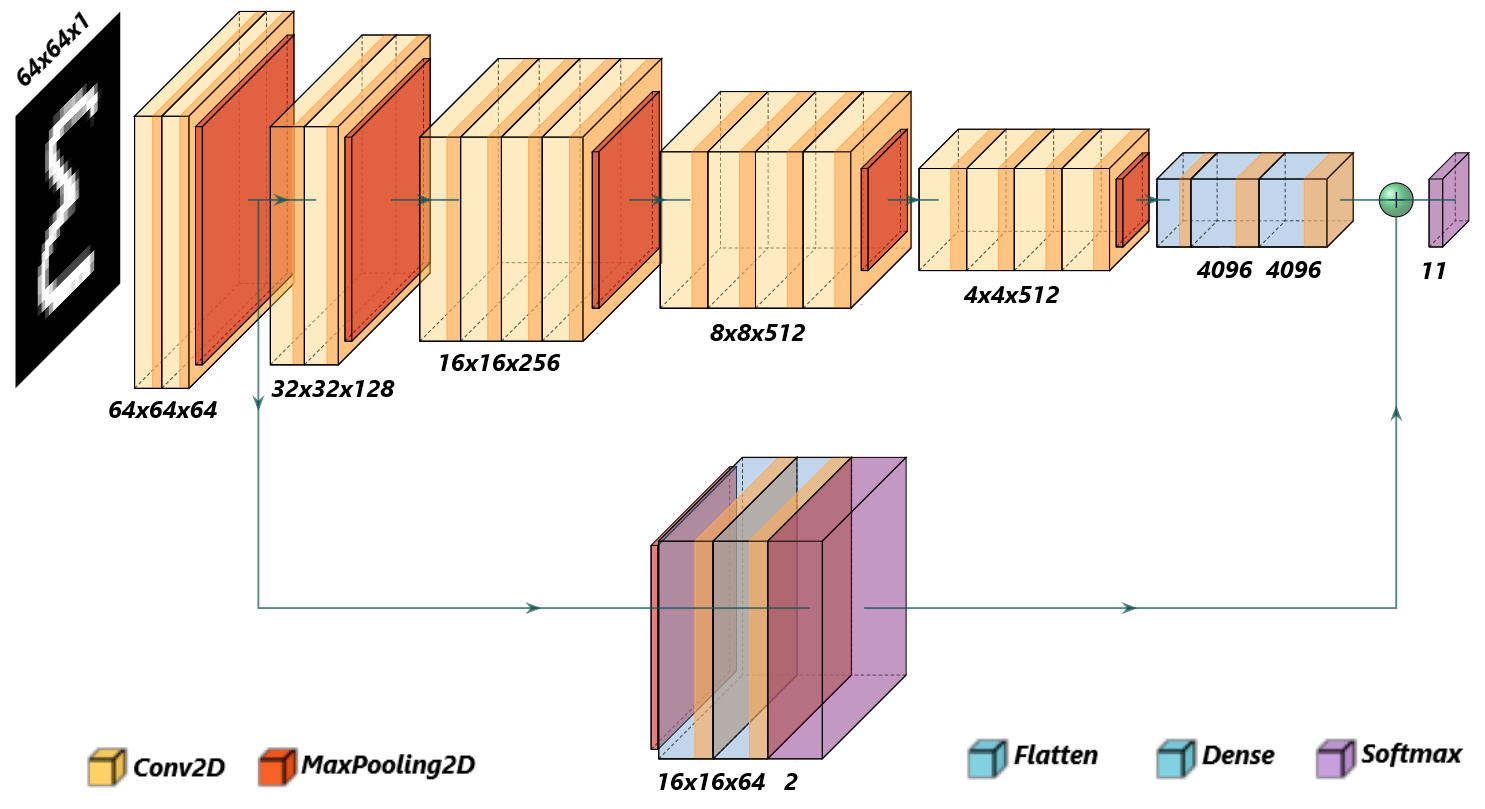
### *Рис.3: Модернізована модель на основі VGG-19 архітектури з реалізованим користувацьким EE-блоком.*

# Data preparation

## Mnist

У наборі даних MNIST є загалом 70000 фотографій вручну написаних цифр розміром 28x28 пікселів, з яких 60000 відведені для тренувального кроку (у поданій роботі розглядалось 48000 для тренування та 12000 для валідації) та 10000 для тестування моделі. Як ціль передбачення (prediction target) для кожного зображення використовується цифра, зображена на ньому. Таким чином MNIST датасет містить загалом 10 різних класів. Розмірність вектора, який визначає формат кольору зображень, в даному датасеті рівна 1. Тобто зображення представлені у форматі градації сірого (grayscale). Для проведення подальших досліджень всі зображення були були переведені у формат 64х64 пікселів з нормалізацією значення самих зображень. Набір даних MNIST використовується в опрацюванні першої експериментальної моделі разом з Omniglot датасетом. MNIST буде вважатись головним датасетом, тобто зображення з цього набору даних мають бути опрацьованими у всіх шарах моделі для їхньої ефективної класифікації.

In [2]:
# Defined size for images for all datasets
img_height = 64
img_width = 64

In [3]:
def preprocess_mnist(X_mnist, X_mnist_test):
    # Expand dimensions of images in order to set dimension of color channel (1 - grayscale; 3 - rgb)  
    X_mnist = X_mnist.reshape((X_mnist.shape + (1,)))
    X_mnist_test = X_mnist_test.reshape((X_mnist_test.shape + (1,)))
    
    # Normalize images for better processing (values in range [0; 1])
    X_mnist = X_mnist.astype('float32')
    X_mnist_test = X_mnist_test.astype('float32')
    X_mnist = X_mnist / 255
    X_mnist_test = X_mnist_test / 255
    
    # Resize images from 28x28 to 64x64 (returns EagerTensor type)
    X_mnist = tf.image.resize_with_pad(
        image=X_mnist,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    X_mnist_test = tf.image.resize_with_pad(
        image=X_mnist_test,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )

    # Convert EagerTensor to numpy array
    X_mnist = X_mnist.numpy()
    X_mnist_test = X_mnist_test.numpy()
    
    return X_mnist, X_mnist_test

In [4]:
(X_mnist, y_mnist), (X_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()

X_mnist, X_mnist_test = preprocess_mnist(X_mnist, X_mnist_test)

from IPython.display import clear_output
clear_output()

## Omniglot

Набір даних Omniglot містить зображення 1623 символів з 50 різних алфавітів. Таким чином датасет містить 32460 зображень, з яких 19280 відведені для тренувального кроку (у поданій роботі розглядалось 15424 для тренування та 3856 для валідації) та 13180 для тестування моделі. Цей набір даних було створено для вивчення проблеми навчання з першого разу (one-shot learning), тобто вивчення завдання лише на одному прикладі. Кожне зображення подане з розміром 105х105 пікселів у форматі RGB. Оскільки зображення з набору даних Omniglot будуть слугувати як надлишкові дані, у поданій роботі значення їх цілей передбачення (1623 класи символів) будуть змінені на 1 клас, який буде позначати всі зображення з цього датасету. Також зображення розглядаються у форматі 64х64 пікселі. Необхідно зазначити, що зображення з надлишкового набору даних мають бути відсіяні на етапі опрацювання Early-Exit блоку, оскільки вони не потребуватимуть подальшої класифікації.

Зображення з Omniglot датасету подані у форматі RGB, тому для ефективного об’єднання цього набору даних з MNIST зображення з Omniglot потрібно перевести у формат градації сірого. Також ці зображення необхідно нормалізувати та значення пікселів інверсувати для асиміляції цих зображень з MNIST датасетом.

In [5]:
# Load omniglot dataset 
(train_val_omniglot_ds, test_omniglot_ds), omniglot_ds_info = tfds.load(
    'omniglot', 
    split=['train', 'test'], 
    as_supervised=True, 
    shuffle_files=True, 
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling omniglot-train.tfrecord...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling omniglot-test.tfrecord...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling omniglot-small1.tfrecord...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling omniglot-small2.tfrecord...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


In [6]:
print('Number of images')
print(f"Training + validation omniglot dataset: {len(train_val_omniglot_ds)}")
print(f"Test omniglot dataset: {len(test_omniglot_ds)}")
print(f"Total: {len(train_val_omniglot_ds) + len(test_omniglot_ds)}")

Number of images
Training + validation omniglot dataset: 19280
Test omniglot dataset: 13180
Total: 32460


In [7]:
def convert_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = 1.0 - image
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_pad(
        image=image,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    label = 10                  # 'non digit' class
    return image, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_val_converted_omniglot_ds = (
    train_val_omniglot_ds
    .map(convert_images)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_converted_omniglot_ds = (
    test_omniglot_ds
    .map(convert_images)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

y_omniglot = np.asarray([y for X, y in train_val_converted_omniglot_ds])
X_omniglot = np.asarray([X for X, y in train_val_converted_omniglot_ds])
y_omniglot_test = np.asarray([y for X, y in test_converted_omniglot_ds])
X_omniglot_test = np.asarray([X for X, y in test_converted_omniglot_ds])

from IPython.display import clear_output
clear_output()

In [9]:
print('Omniglot dataset (transformed)')
print(f'Train: X={X_omniglot.shape}, y={y_omniglot.shape}')
print(f'Test: X={X_omniglot_test.shape}, y={y_omniglot_test.shape}')

Omniglot dataset (transformed)
Train: X=(19280, 64, 64, 1), y=(19280,)
Test: X=(13180, 64, 64, 1), y=(13180,)


# Subclassing implementation

### *Діаграма класів, використаних у поданій роботі*
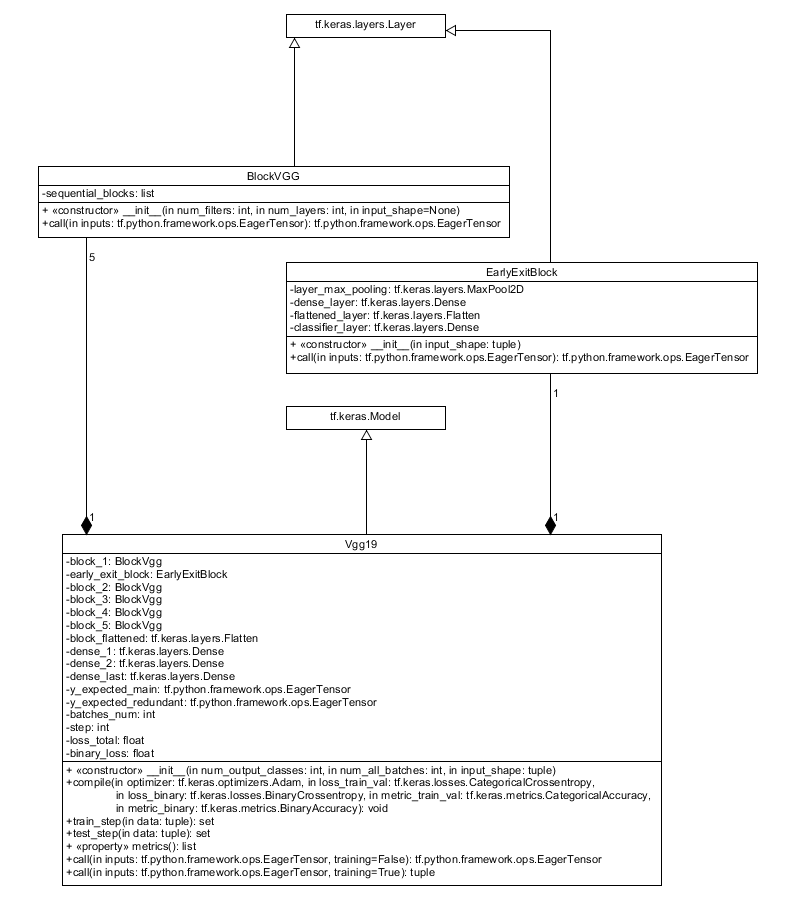

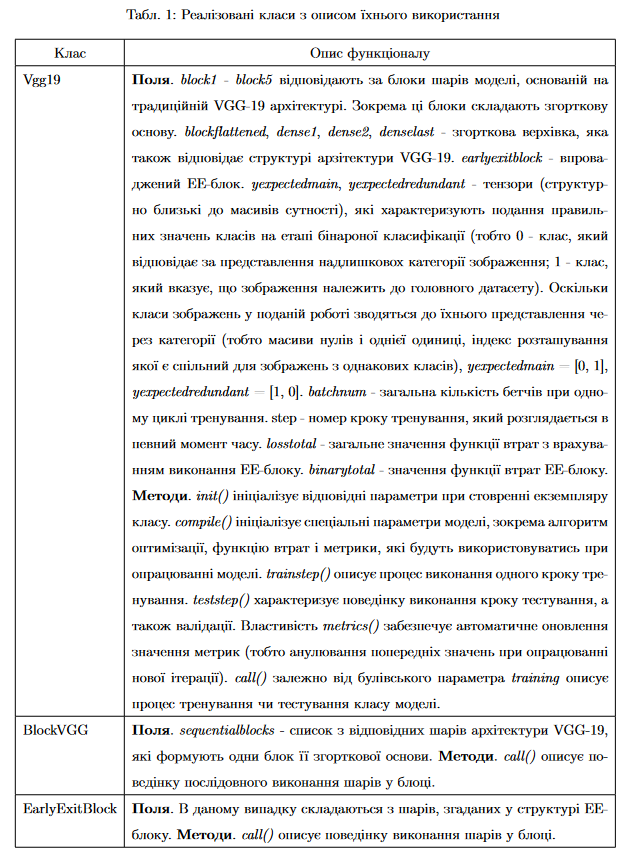

In [10]:
class BlockVgg(tf.keras.layers.Layer):
  def __init__(self, *, num_filters: int, num_layers: int, input_shape=None):
    super().__init__()
    self.sequential_blocks = []
    for num_layer in range(num_layers):
      if input_shape is not None:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, input_shape=input_shape, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
      else:
        self.sequential_blocks.append(tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same', activation=tf.keras.layers.ReLU()))
    self.sequential_blocks.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
  
  def call(self, inputs):
    output = self.sequential_blocks[0](inputs)
    for layer in self.sequential_blocks[1:]:
      output = layer(output)
    
    return output


In [11]:
class EarlyExitBlock(tf.keras.layers.Layer):
  def __init__(self, input_shape):
    super().__init__()
    self.layer_max_pooling = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
    self.dense_layer = tf.keras.layers.Dense(64, activation=tf.keras.layers.ReLU())
    self.flattened_layer = tf.keras.layers.Flatten()
    self.classifier_layer = tf.keras.layers.Dense(2, activation=tf.keras.layers.Softmax())
  

  def call(self, inputs):
    output = self.layer_max_pooling(inputs)
    output = self.flattened_layer(output)
    output = self.dense_layer(output)
    output = self.classifier_layer(output)

    return output


In [12]:
class Vgg19(tf.keras.Model):
  def __init__(self, num_output_classes: int, input_shape) -> None:
    super().__init__()

    self.block_1 = BlockVgg(num_filters=64, num_layers=2, input_shape=input_shape)

    self.early_exit_block = EarlyExitBlock(input_shape=(input_shape[0]/2, 
                                                        input_shape[1]/2))

    self.block_2 = BlockVgg(num_filters=128, num_layers=2)
    self.block_3 = BlockVgg(num_filters=256, num_layers=4)
    self.block_4 = BlockVgg(num_filters=512, num_layers=4)
    self.block_5 = BlockVgg(num_filters=512, num_layers=4)
        
    self.block_flattened = tf.keras.layers.Flatten()

    self.dense_1 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_2 = tf.keras.layers.Dense(4096, activation=tf.keras.layers.ReLU())
    self.dense_last = tf.keras.layers.Dense(num_output_classes, activation='softmax')
    
    # Variables for calculating loss
    self.NON_DIGIT = 0
    self.IS_DIGIT = 1

    self.y_expected_mnist = tf.one_hot([self.IS_DIGIT], 2)
    self.y_expected_omniglot = tf.one_hot([self.NON_DIGIT], 2)
    
    self.step = 0
    self.loss_total = 0
    self.binary_loss = 0
    
    
    
  def compile(self, optimizer, loss_train_val, loss_binary, metric_train_val, metric_binary):
    super(Vgg19, self).compile()
    # Optimizer
    self.optimizer = optimizer

    # Losses
    self.compiled_loss = loss_train_val
    self.binary_crossentropy_loss = loss_binary

    # Metrics
    self.compiled_metrics = metric_train_val
    self.binary_acc_metric = metric_binary
    
    # Metrics for tracking losses
    self.loss_tracker_train = tf.keras.metrics.Mean()
    self.loss_tracker_val = tf.keras.metrics.Mean()
    self.loss_tracker_binary = tf.keras.metrics.Mean()
    
    
    
  # Train step used in .fit(X, y) 
  def train_step(self, data):     # should be (x, y)
    x_current_batch, y_current_batch = data
    
    with tf.GradientTape() as tape:

      # feed first mnist, then omniglot

      if self.step % 4 != 0:
        # print('mnist')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)  # training true parameter
        output_expected = y_current_batch

        # 10 classes classification loss
        loss_classification = self.compiled_loss(output_expected, classification_output_actual)

        # early exit classification loss for mnist
        y_expected_mnist_batch = tf.repeat(self.y_expected_mnist, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_mnist_batch, early_exit_output_actual)

        # taking average of these losses in case this is digit value
        self.loss_total = loss_classification + loss_early_exit
        
        # calculate binary loss within mnist (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_mnist_batch, early_exit_output_actual)

        # update training metric for mnist (EE + classification)
        self.compiled_metrics.update_state(y_expected_mnist_batch, early_exit_output_actual)
        self.compiled_metrics.update_state(output_expected, classification_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_mnist_batch, early_exit_output_actual)

      else:
        # print('omni')

        early_exit_output_actual, classification_output_actual = self(x_current_batch, training=True)    # training true parameter
        output_expected = y_current_batch

        # in case of non-digit class we don't calculate loss for 10 classes classification  part of network
        # this may produce warnings from tensorflow, check the names of the layers and if they are as expected, just ignore this warning

        y_expected_omniglot_batch = tf.repeat(self.y_expected_omniglot, 64, axis=0)
        loss_early_exit = self.compiled_loss(y_expected_omniglot_batch, early_exit_output_actual)

        # take loss only for early-exit block
        self.loss_total = loss_early_exit
        
        # calculate binary loss within omniglot (EE block result)
        self.binary_loss = self.binary_crossentropy_loss(y_expected_omniglot_batch, early_exit_output_actual)

        # update training metric for mnist (only EE)
        self.compiled_metrics.update_state(y_expected_omniglot_batch, early_exit_output_actual)

        # update training metric for binary classification (EE)
        self.binary_acc_metric.update_state(y_expected_omniglot_batch, early_exit_output_actual)

    # choose correct weights here
    weights = self.trainable_weights

    gradients = tape.gradient(self.loss_total, weights)
    self.optimizer.apply_gradients(zip(gradients, weights))
    
    self.loss_tracker_train.update_state(self.loss_total)
    self.loss_tracker_binary.update_state(self.binary_loss)
    
    self.step += 1
    
    if (self.step == 991):
        self.step = 0

    return {"Training loss": self.loss_tracker_train.result(), "Training acc": self.compiled_metrics.result(), "Binary loss": self.loss_tracker_binary.result(), "Binary acc": self.binary_acc_metric.result()}



  def test_step(self, data):
    x_batch, y_batch = data
    
    # Compute predictions
    output_actual = vgg_19_test(x_batch, training=False)

    # Calculate validation loss
    val_loss = self.compiled_loss(y_batch, output_actual)
    self.loss_tracker_val.update_state(val_loss)

    # Update val metrics
    self.compiled_metrics.update_state(y_batch, output_actual)
    
    return {"Validation loss": self.loss_tracker_val.result(), "Validation acc": self.compiled_metrics.result()}


    
  @property
  def metrics(self):
    # `Metric` objects here so that `reset_states()` can be called automatically at the start of each epoch or at the start of `evaluate()`
    return [self.compiled_metrics, self.binary_acc_metric, self.loss_tracker_train, self.loss_tracker_val, self.loss_tracker_binary]

    

  def call(self, inputs, training=None):
    typical_output = self.block_1(inputs)

    early_exit_output = self.early_exit_block(typical_output)

    if not training:
        output_for_val_or_test = np.empty([inputs.shape[0], 11])
        
        anticipated_mnist_or_omni_result = np.argmax(early_exit_output, axis=1)     # 0 when NON_DIGIT; 1 when DIGIT
        indeces_for_omni = np.argwhere(anticipated_mnist_or_omni_result == 0)
        indeces_for_mnist = np.argwhere(anticipated_mnist_or_omni_result == 1)
        num_of_mnist_in_batch = np.count_nonzero(anticipated_mnist_or_omni_result)
        
        if len(indeces_for_omni) > 0:
            # insert tensors defining omniglot images for specific indeces, where omniglot images were defined in EE
            np.put_along_axis(output_for_val_or_test, indeces_for_omni, np.squeeze(tf.one_hot([10], 11)), axis=0)
            
        if len(indeces_for_mnist) == 0:
            #print("indeces_for_mnist IS EMPTY")
            return output_for_val_or_test
        
        # modify mnsit indeces
        indeces_for_mnist = np.squeeze(indeces_for_mnist, axis=1)
        
        # take to classificstion step only those images which are from mnist
        typical_output = np.take(typical_output, indeces_for_mnist, axis=0)
        

    typical_output = self.block_2(typical_output)
    typical_output = self.block_3(typical_output)
    typical_output = self.block_4(typical_output)
    typical_output = self.block_5(typical_output)

    typical_output = self.block_flattened(typical_output)

    typical_output = self.dense_1(typical_output)
    typical_output = self.dense_2(typical_output)
    typical_output = self.dense_last(typical_output)

    if training:
        return early_exit_output, typical_output
    else:
        # modify mnist indeces back
        indeces_for_mnist = np.expand_dims(indeces_for_mnist, axis=1)
        
        # insert tensors defining mnist images for specific indeces, where mnist images were defined in full vgg-19 classification
        np.put_along_axis(output_for_val_or_test, indeces_for_mnist, np.squeeze(typical_output), axis=0)
        
        return output_for_val_or_test

# Subclassing usage

In [13]:
NON_DIGIT = 0
IS_DIGIT = 1

y_expected_mnist = tf.one_hot([IS_DIGIT], 2)
y_expected_omniglot = tf.one_hot([NON_DIGIT], 2)

print(f"y_expected_mnist: {y_expected_mnist}; y_expected_omniglot: {y_expected_omniglot}")

y_expected_mnist: [[0. 1.]]; y_expected_omniglot: [[1. 0.]]


In [14]:
X_omniglot.shape[0]

19280

In [15]:
X_mnist.shape[0]

60000

## Train/Test split of datasets 

In [16]:
# Train / test (validation) split of mnist
X_mnist_train, X_mnist_val, y_mnist_train, y_mnist_val = train_test_split(X_mnist, y_mnist, train_size=0.8, test_size=0.2, random_state=0)

In [17]:
y_mnist_val.shape

(12000,)

In [18]:
# Train / test (validation) split of omniglot
X_omniglot_train, X_omniglot_val, y_omniglot_train, y_omniglot_val = train_test_split(X_omniglot, y_omniglot, train_size=0.8, test_size=0.2, random_state=0)

In [19]:
y_omniglot_train.shape

(15424,)

### Concatenation of MNIST and Omniglot datasets for validation and testing step

In [20]:
X_mnist_omni_val = np.concatenate((X_mnist_val, X_omniglot_val), axis=0)
y_mnist_omni_val = np.concatenate((y_mnist_val, y_omniglot_val), axis=0)

X_mnist_omni_test = np.concatenate((X_mnist_test, X_omniglot_test), axis=0)
y_mnist_omni_test = np.concatenate((y_mnist_test, y_omniglot_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X_mnist_omni_val, y_mnist_omni_val = shuffle(X_mnist_omni_val, y_mnist_omni_val)
X_mnist_omni_test, y_mnist_omni_test = shuffle(X_mnist_omni_test, y_mnist_omni_test)

In [21]:
# 11 classes for validation and testing targets
y_mnist_omni_val = tf.keras.utils.to_categorical(y_mnist_omni_val)
y_mnist_omni_test = tf.keras.utils.to_categorical(y_mnist_omni_test)

In [22]:
print(f'Validation: X={X_mnist_omni_val.shape}, y={y_mnist_omni_val.shape}')
print(f'Test: X={X_mnist_omni_test.shape}, y={y_mnist_omni_test.shape}')

Validation: X=(15856, 64, 64, 1), y=(15856, 11)
Test: X=(23180, 64, 64, 1), y=(23180, 11)


## Merge MNIST and Omniglot datasets for training in right order

In [23]:
# For training
bs = 64
num_batches_mnist = int(X_mnist_train.shape[0]/bs)
num_batches_omniglot =  int(X_omniglot_train.shape[0]/bs)

times_datasets_differ_in = int(num_batches_mnist/num_batches_omniglot)

In [24]:
X_mnist_train_reshape = np.reshape(X_mnist_train, (num_batches_mnist, bs, 64,64,1)) 
X_mnist_train_reshape.shape

(750, 64, 64, 64, 1)

In [25]:
X_omniglot_train_reshape = np.reshape(X_omniglot_train, (num_batches_omniglot, bs, 64,64,1)) 
X_omniglot_train_reshape.shape

(241, 64, 64, 64, 1)

In [26]:
X_mnist_omni_train = np.insert(X_mnist_train_reshape, np.arange(0, num_batches_omniglot*times_datasets_differ_in, times_datasets_differ_in), X_omniglot_train_reshape, axis=0)

In [27]:
y_mnist_train_reshape = np.reshape(y_mnist_train, (num_batches_mnist, bs)) 
y_mnist_train_reshape.shape

(750, 64)

In [28]:
y_omniglot_train_reshape = np.reshape(y_omniglot_train, (num_batches_omniglot, bs)) 
y_omniglot_train_reshape.shape

(241, 64)

In [29]:
y_mnist_omni_train = np.insert(y_mnist_train_reshape, np.arange(0, num_batches_omniglot*times_datasets_differ_in, times_datasets_differ_in), y_omniglot_train_reshape, axis=0)

In [30]:
X_mnist_omni_train.shape

(991, 64, 64, 64, 1)

In [31]:
# 11 classes for training targets as well
y_mnist_omni_train = tf.keras.utils.to_categorical(y_mnist_omni_train)

In [32]:
y_mnist_omni_train.shape

(991, 64, 11)

In [33]:
# MAKE SHAPE (..., 64,64,1)
X_mnist_omni_train = np.reshape(X_mnist_omni_train, ((num_batches_omniglot+num_batches_mnist)*bs,64,64,1)) 
X_mnist_omni_train.shape

(63424, 64, 64, 1)

In [34]:
# MAKE SHAPE (..., 11)
y_mnist_omni_train = np.reshape(y_mnist_omni_train, ((num_batches_omniglot+num_batches_mnist)*bs,11)) 
y_mnist_omni_train.shape

(63424, 11)

In [35]:
num_batches_mnist

750

In [36]:
num_batches_omniglot

241

## Training and Evaluation

In [37]:
vgg_19_test = Vgg19(11, (img_height, img_width, 1))

In [38]:
vgg_19_test.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
                    loss_train_val=tf.keras.losses.CategoricalCrossentropy(),
                    loss_binary=tf.keras.losses.BinaryCrossentropy(),
                    metric_train_val=tf.keras.metrics.CategoricalAccuracy(),
                    metric_binary=tf.keras.metrics.BinaryAccuracy())

In [39]:
tf.config.run_functions_eagerly(True)

history_vgg_19_test = vgg_19_test.fit(
    X_mnist_omni_train, y_mnist_omni_train,
    validation_data=(X_mnist_omni_val, y_mnist_omni_val),
    batch_size=64,
    epochs=5,
    steps_per_epoch=num_batches_mnist+num_batches_omniglot,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/5
991/991 [==============================] - 151s 138ms/step - Training loss: 1.9533 - Training acc: 0.5704 - Binary loss: 0.2044 - Binary acc: 0.9065 - val_Validation loss: 1.9947 - val_Validation acc: 0.7371
Epoch 2/5
991/991 [==============================] - 132s 133ms/step - Training loss: 0.3069 - Training acc: 0.9455 - Binary loss: 0.0542 - Binary acc: 0.9825 - val_Validation loss: 0.9349 - val_Validation acc: 0.9060
Epoch 3/5
991/991 [==============================] - 132s 133ms/step - Training loss: 0.1094 - Training acc: 0.9807 - Binary loss: 0.0507 - Binary acc: 0.9843 - val_Validation loss: 0.0653 - val_Validation acc: 0.9842
Epoch 4/5
991/991 [==============================] - 129s 130ms/step - Training loss: 0.0716 - Training acc: 0.9935 - Binary loss: 0.0356 - Binary acc: 0.9990 - val_Validation loss: 0.0670 - val_Validation acc: 0.9892
Epoch 5/5
991/991 [==============================] - 137s 138ms/step - Training loss: 0.0494 - Training acc: 0.9952 - Binary los

In [40]:
score_omni_mnist = vgg_19_test.evaluate(X_mnist_omni_test, y_mnist_omni_test)
print('Test loss:', score_omni_mnist[1])
print('Test score:', score_omni_mnist[0])

print("CNN Error: %.2f%%" % (100-score_omni_mnist[0]*100))

725/725 [==============================] - 26s 35ms/step - Validation loss: 0.3927 - Validation acc: 0.9722
Test loss: 0.3972642421722412
Test score: 0.9718723297119141
CNN Error: 2.81%


Minimum validation loss on omniglot + mnist datasets: 0.0653304010629654


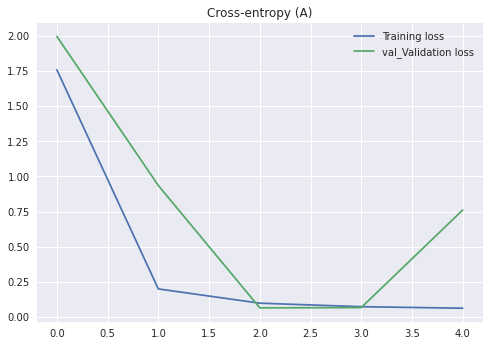

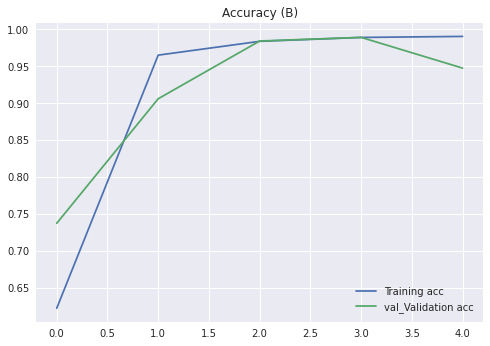

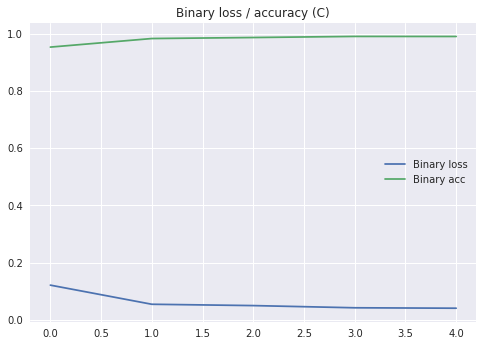

In [41]:
history_vgg_19_test_frame = pd.DataFrame(history_vgg_19_test.history)
history_vgg_19_test_frame.loc[:, ['Training loss', 'val_Validation loss']].plot(title="Cross-entropy (A)")
history_vgg_19_test_frame.loc[:, ['Training acc', 'val_Validation acc']].plot(title="Accuracy (B)");
history_vgg_19_test_frame.loc[:, ['Binary loss', 'Binary acc']].plot(title="Binary loss / accuracy (C)");

print("Minimum validation loss on omniglot + mnist datasets: {}".format(history_vgg_19_test_frame['val_Validation loss'].min()))

## Prediction, inference time, confusion matrix

In [42]:
# GPU T4 x2, batch_size = 32 (default)
start_time = time.time()
#Predict y_test values for comparison in confusion matrix (omniglot + mnist, 11 classes)
y_test_pred = vgg_19_test.predict(X_mnist_omni_test)
elapsed = time.time() - start_time

y_test_true = y_mnist_omni_test

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (omniglot + mnist dataset, 11 classes): {np.round(elapsed / len(X_mnist_omni_test), 6)} sec.")

Inference time for all samples: 17.140628 sec.
Average inference time for 1 sample (omniglot + mnist dataset, 11 classes): 0.000739 sec.


In [43]:
# GPU T4 x2, batch_size = 64
start_time = time.time()
#Predict y_test values for comparison in confusion matrix (omniglot + mnist, 11 classes)
y_test_pred_omniglot_and_mnist_64 = vgg_19_test.predict(X_mnist_omni_test, batch_size = 64)
elapsed = time.time() - start_time

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (omniglot + mnist dataset, 11 classes): {np.round(elapsed / len(X_mnist_omni_test), 6)} sec.")

Inference time for all samples: 18.159497 sec.
Average inference time for 1 sample (omniglot + mnist dataset, 11 classes): 0.000783 sec.


In [44]:
# GPU T4 x2, batch_size = 1
start_time = time.time()
#Predict y_test (omniglot + mnist, 11 classes)
y_test_pred_omniglot_and_mnist = vgg_19_test.predict(X_mnist_omni_test, batch_size=1)  
elapsed = time.time() - start_time

start_time1 = time.time()
#Predict y_test (mnist, 11 classes)
y_test_pred_mnist = vgg_19_test.predict(X_mnist_test, batch_size=1)
elapsed1 = time.time() - start_time1

start_time2 = time.time()
#Predict y_test (omniglot, 11 classes)
y_test_pred_omniglot = vgg_19_test.predict(X_omniglot_test, batch_size=1)
elapsed2 = time.time() - start_time2

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (omniglot + mnist dataset, 11 classes): {np.round(elapsed / len(X_mnist_omni_test), 6)} sec.")
print(f"Inference time for all samples: {np.round(elapsed1, 6)} sec.\nAverage inference time for 1 sample (mnist dataset, 11 classes): {np.round(elapsed1 / len(X_mnist_test), 6)} sec.")
print(f"Inference time for all samples: {np.round(elapsed2, 6)} sec.\nAverage inference time for 1 sample (omniglot dataset, 11 classes): {np.round(elapsed2 / len(X_omniglot_test), 6)} sec.")

Inference time for all samples: 209.552696 sec.
Average inference time for 1 sample (omniglot + mnist dataset, 11 classes): 0.00904 sec.
Inference time for all samples: 202.254695 sec.
Average inference time for 1 sample (mnist dataset, 11 classes): 0.020225 sec.
Inference time for all samples: 82.359463 sec.
Average inference time for 1 sample (omniglot dataset, 11 classes): 0.006249 sec.


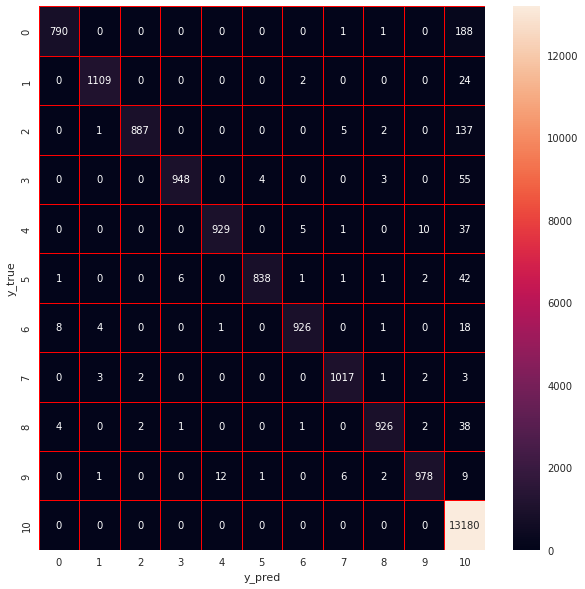

In [45]:
#Confusion matrix for mnist + omniglot evaluation data
omniglot_mnist_cm=confusion_matrix(y_test_true.argmax(axis=1), y_test_pred.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(omniglot_mnist_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Other metrics and results

In [46]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "char"]
def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.gray)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

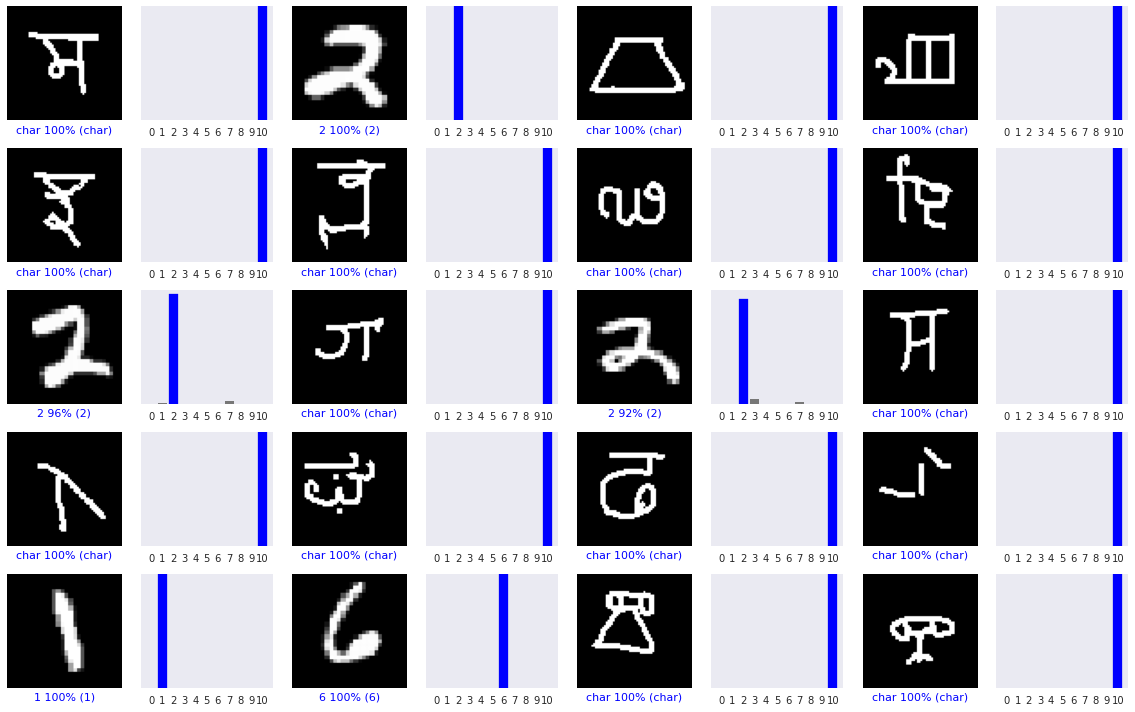

In [47]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred[i+20], y_test_true[i+20], X_mnist_omni_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred[i+20], y_test_true[i+20])
plt.tight_layout()
plt.show()